<a href="https://colab.research.google.com/github/Kadakol/ML/blob/master/NYU%20Deep%20Learning%20DS-GA%201008/Spring%202020/Practicum/04_spiral_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from matplotlib import pyplot as plt
import numpy as np
import torch
from IPython.display import HTML, display


def set_default(figsize=(10, 10), dpi=100):
    plt.style.use(['dark_background', 'bmh'])
    plt.rc('axes', facecolor='k')
    plt.rc('figure', facecolor='k')
    plt.rc('figure', figsize=figsize, dpi=dpi)


def plot_data(X, y, d=0, auto=False, zoom=1):
    X = X.cpu()
    y = y.cpu()
    plt.scatter(X.numpy()[:, 0], X.numpy()[:, 1], c=y, s=20, cmap=plt.cm.Spectral)
    plt.axis('square')
    plt.axis(np.array((-1.1, 1.1, -1.1, 1.1)) * zoom)
    if auto is True: plt.axis('equal')
    plt.axis('off')

    _m, _c = 0, '.15'
    plt.axvline(0, ymin=_m, color=_c, lw=1, zorder=0)
    plt.axhline(0, xmin=_m, color=_c, lw=1, zorder=0)


def plot_model(X, y, model):
    model.cpu()
    mesh = np.arange(-1.1, 1.1, 0.01)
    xx, yy = np.meshgrid(mesh, mesh)
    with torch.no_grad():
        data = torch.from_numpy(np.vstack((xx.reshape(-1), yy.reshape(-1))).T).float()
        Z = model(data).detach()
    Z = np.argmax(Z, axis=1).reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.3)
    plot_data(X, y)


def show_scatterplot(X, colors, title=''):
    colors = colors.cpu().numpy()
    X = X.cpu().numpy()
    plt.figure()
    plt.axis('equal')
    plt.scatter(X[:, 0], X[:, 1], c=colors, s=30)
    # plt.grid(True)
    plt.title(title)
    plt.axis('off')


def plot_bases(bases, width=0.04):
    bases = bases.cpu()
    bases[2:] -= bases[:2]
    plt.arrow(*bases[0], *bases[2], width=width, color=(1,0,0), zorder=10, alpha=1., length_includes_head=True)
    plt.arrow(*bases[1], *bases[3], width=width, color=(0,1,0), zorder=10, alpha=1., length_includes_head=True)


def show_mat(mat, vect, prod, threshold=-1):
    # Subplot grid definition
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharex=False, sharey=True,
                                        gridspec_kw={'width_ratios':[5,1,1]})
    # Plot matrices
    cax1 = ax1.matshow(mat.numpy(), clim=(-1, 1))
    ax2.matshow(vect.numpy(), clim=(-1, 1))
    cax3 = ax3.matshow(prod.numpy(), clim=(threshold, 1))

    # Set titles
    ax1.set_title(f'A: {mat.size(0)} \u00D7 {mat.size(1)}')
    ax2.set_title(f'a^(i): {vect.numel()}')
    ax3.set_title(f'p: {prod.numel()}')

    # Remove xticks for vectors
    ax2.set_xticks(tuple())
    ax3.set_xticks(tuple())
    
    # Plot colourbars
    fig.colorbar(cax1, ax=ax2)
    fig.colorbar(cax3, ax=ax3)

    # Fix y-axis limits
    ax1.set_ylim(bottom=max(len(prod), len(vect)) - 0.5)


colors = dict(
    aqua='#8dd3c7',
    yellow='#ffffb3',
    lavender='#bebada',
    red='#fb8072',
    blue='#80b1d3',
    orange='#fdb462',
    green='#b3de69',
    pink='#fccde5',
    grey='#d9d9d9',
    violet='#bc80bd',
    unk1='#ccebc5',
    unk2='#ffed6f',
)


def _cstr(s, color='black'):
    if s == ' ':
        return f'<text style=color:#000;padding-left:10px;background-color:{color}> </text>'
    else:
        return f'<text style=color:#000;background-color:{color}>{s} </text>'

# print html
def _print_color(t):
    display(HTML(''.join([_cstr(ti, color=ci) for ti, ci in t])))

# get appropriate color for value
def _get_clr(value):
    colors = ('#85c2e1', '#89c4e2', '#95cae5', '#99cce6', '#a1d0e8',
              '#b2d9ec', '#baddee', '#c2e1f0', '#eff7fb', '#f9e8e8',
              '#f9e8e8', '#f9d4d4', '#f9bdbd', '#f8a8a8', '#f68f8f',
              '#f47676', '#f45f5f', '#f34343', '#f33b3b', '#f42e2e')
    value = int((value * 100) / 5)
    if value == len(colors): value -= 1  # fixing bugs...
    return colors[value]

def _visualise_values(output_values, result_list):
    text_colours = []
    for i in range(len(output_values)):
        text = (result_list[i], _get_clr(output_values[i]))
        text_colours.append(text)
    _print_color(text_colours)

def print_colourbar():
    color_range = torch.linspace(-2.5, 2.5, 20)
    to_print = [(f'{x:.2f}', _get_clr((x+2.5)/5)) for x in color_range]
    _print_color(to_print)


# Let's only focus on the last time step for now
# First, the cell state (Long term memory)
def plot_state(data, state, b, decoder):
    actual_data = decoder(data[b, :, :].numpy())
    seq_len = len(actual_data)
    seq_len_w_pad = len(state)
    for s in range(state.size(2)):
        states = torch.sigmoid(state[:, b, s])
        _visualise_values(states[seq_len_w_pad - seq_len:], list(actual_data))

# Create the data

In [2]:
import random
import torch
from torch import nn, optim
import math
from IPython import display

In [3]:
set_default()

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
seed = 12345
random.seed(seed)
torch.manual_seed(seed)
N = 1000  # num_samples_per_class
D = 2  # dimensions
C = 3  # num_classes
H = 100  # num_hidden_units

In [6]:

X = torch.zeros(N * C, D).to(device)
y = torch.zeros(N * C, dtype=torch.long).to(device)
for c in range(C):
    index = 0
    t = torch.linspace(0, 1, N)
    # When c = 0 and t = 0: start of linspace
    # When c = 0 and t = 1: end of linpace
    # This inner_var is for the formula inside sin() and cos() like sin(inner_var) and cos(inner_Var)
    inner_var = torch.linspace(
        # When t = 0
        (2 * math.pi / C) * (c),
        # When t = 1
        (2 * math.pi / C) * (2 + c),
        N
    ) + torch.randn(N) * 0.2
    
    for ix in range(N * c, N * (c + 1)):
        X[ix] = t[index] * torch.FloatTensor((
            math.sin(inner_var[index]), math.cos(inner_var[index])
        ))
        y[ix] = c
        index += 1

print("Shapes:")
print("X:", tuple(X.size()))
print("y:", tuple(y.size()))

Shapes:
X: (3000, 2)
y: (3000,)


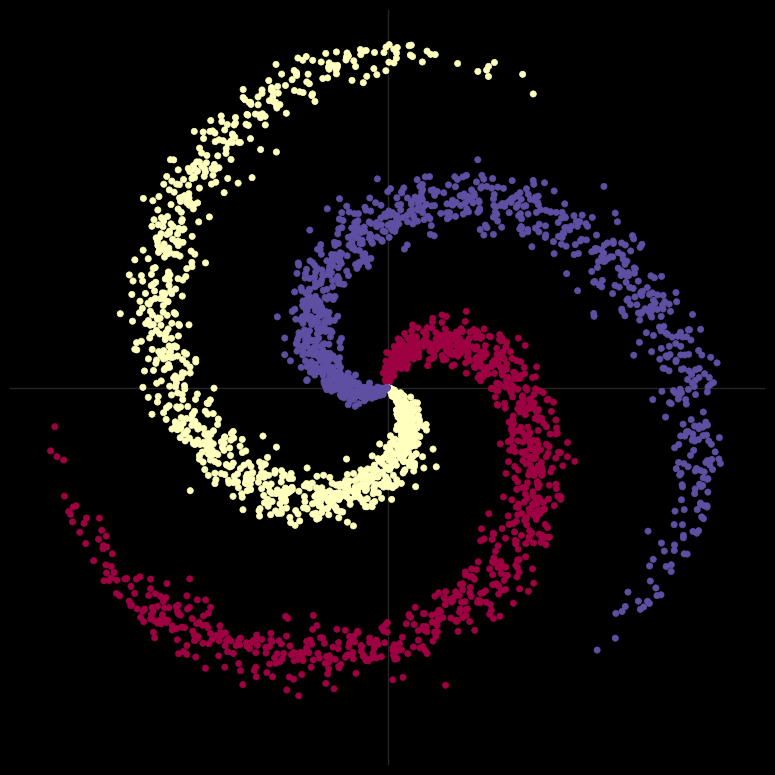

In [7]:
# visualise the data
plot_data(X, y)

# Linear Model

In [8]:
learning_rate = 1e-3
lambda_l2 = 1e-5

In [9]:
# nn package to create our linear model
# each Linear module has a weight and bias
model = nn.Sequential(
    nn.Linear(D, H),
    nn.Linear(H, C)
)
model.to(device) #Convert to CUDA

# nn package also has different loss functions.
# we use cross entropy loss for our classification task
criterion = torch.nn.CrossEntropyLoss()

# we use the optim package to apply
# stochastic gradient descent for our parameter updates
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=lambda_l2) # built-in L2

# Training
for t in range(1000):
    
    # Feed forward to get the logits
    y_pred = model(X)
    
    # Compute the loss and accuracy
    loss = criterion(y_pred, y)
    score, predicted = torch.max(y_pred, 1)
    acc = (y == predicted).sum().float() / len(y)
    print("[EPOCH]: %i, [LOSS]: %.6f, [ACCURACY]: %.3f" % (t, loss.item(), acc))
    display.clear_output(wait=True)
    
    # zero the gradients before running
    # the backward pass.
    optimizer.zero_grad()
    
    # Backward pass to compute the gradient
    # of loss w.r.t our learnable params. 
    loss.backward()
    
    # Update params
    optimizer.step()

[EPOCH]: 999, [LOSS]: 0.861541, [ACCURACY]: 0.504


Sequential(
  (0): Linear(in_features=2, out_features=100, bias=True)
  (1): Linear(in_features=100, out_features=3, bias=True)
)


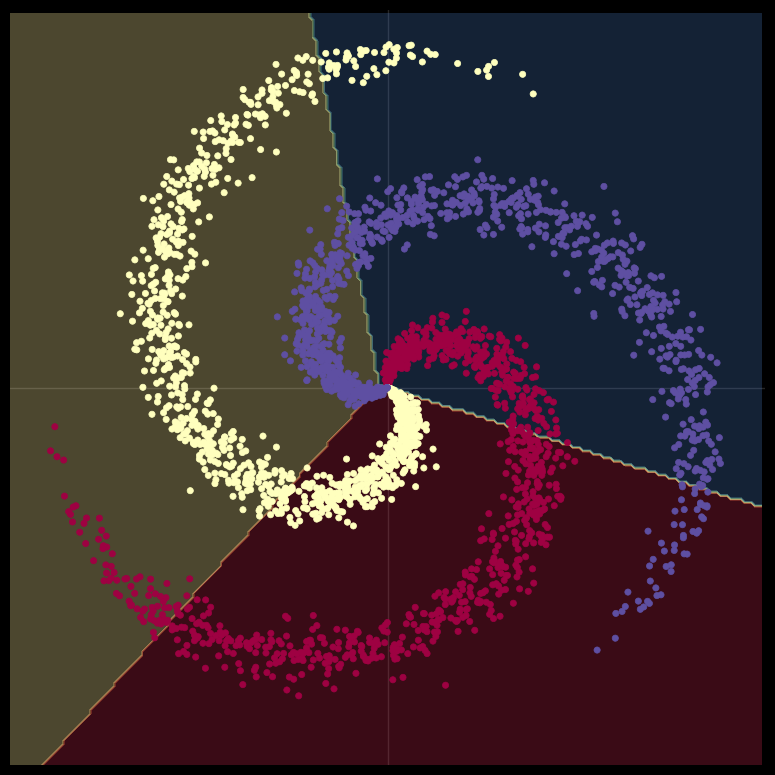

In [10]:
# Plot trained model
print(model)
plot_model(X, y, model)

# Two Layer Network

In [11]:
learning_rate = 1e-3
lambda_l2 = 1e-5

In [14]:
model = nn.Sequential(
    nn.Linear(D, H),
    nn.ReLU(),
    nn.Linear(H, C)
)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=lambda_l2)

for t in range(1000):
  y_pred = model(X)
  loss = criterion(y_pred, y)
  score, predicted = torch.max(y_pred, 1)
  acc = (y == predicted).sum().float() / len(y)
  print("[EPOCH]: %i, [LOSS]: %.6f, [ACCURACY]: %.3f" % (t, loss.item(), acc))
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()


[EPOCH]: 0, [LOSS]: 1.069334, [ACCURACY]: 0.344
[EPOCH]: 1, [LOSS]: 1.063384, [ACCURACY]: 0.373
[EPOCH]: 2, [LOSS]: 1.057523, [ACCURACY]: 0.401
[EPOCH]: 3, [LOSS]: 1.051750, [ACCURACY]: 0.415
[EPOCH]: 4, [LOSS]: 1.046062, [ACCURACY]: 0.452
[EPOCH]: 5, [LOSS]: 1.040461, [ACCURACY]: 0.463
[EPOCH]: 6, [LOSS]: 1.034943, [ACCURACY]: 0.472
[EPOCH]: 7, [LOSS]: 1.029507, [ACCURACY]: 0.478
[EPOCH]: 8, [LOSS]: 1.024152, [ACCURACY]: 0.482
[EPOCH]: 9, [LOSS]: 1.018875, [ACCURACY]: 0.488
[EPOCH]: 10, [LOSS]: 1.013675, [ACCURACY]: 0.493
[EPOCH]: 11, [LOSS]: 1.008551, [ACCURACY]: 0.497
[EPOCH]: 12, [LOSS]: 1.003502, [ACCURACY]: 0.501
[EPOCH]: 13, [LOSS]: 0.998524, [ACCURACY]: 0.502
[EPOCH]: 14, [LOSS]: 0.993617, [ACCURACY]: 0.505
[EPOCH]: 15, [LOSS]: 0.988778, [ACCURACY]: 0.509
[EPOCH]: 16, [LOSS]: 0.984006, [ACCURACY]: 0.514
[EPOCH]: 17, [LOSS]: 0.979299, [ACCURACY]: 0.518
[EPOCH]: 18, [LOSS]: 0.974655, [ACCURACY]: 0.521
[EPOCH]: 19, [LOSS]: 0.970073, [ACCURACY]: 0.522
[EPOCH]: 20, [LOSS]: 0.965554,

Sequential(
  (0): Linear(in_features=2, out_features=100, bias=True)
  (1): ReLU()
  (2): Linear(in_features=100, out_features=3, bias=True)
)


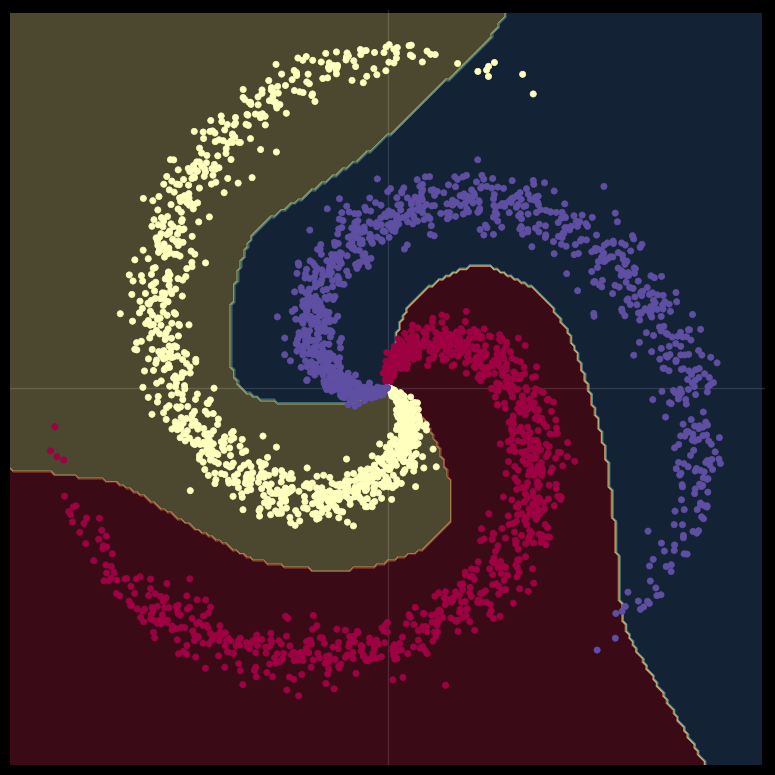

In [15]:
print(model)
plot_model(X, y, model)

# Try with 2 hidden layers

In [18]:
lr = 1e-3
lambda_l2 = 1e-5

model = nn.Sequential(
    nn.Linear(D, H),
    nn.ReLU(),
    nn.Linear(H, H),
    nn.ReLU(),
    nn.Linear(H, C)
)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=lambda_l2)

for t in range(1000):
  y_pred = model(X)
  loss = criterion(y_pred, y)
  score, predicted = torch.max(y_pred, 1)
  acc = (predicted == y).sum().float() / len(y)
  print(f'Epoch = {t}\tLoss = {loss:.6f}\tAccuracy = {acc:.3f}')
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

Epoch = 0	Loss = 1.096321	Accuracy = 0.333
Epoch = 1	Loss = 1.082641	Accuracy = 0.378
Epoch = 2	Loss = 1.069591	Accuracy = 0.443
Epoch = 3	Loss = 1.057208	Accuracy = 0.468
Epoch = 4	Loss = 1.045222	Accuracy = 0.584
Epoch = 5	Loss = 1.033855	Accuracy = 0.618
Epoch = 6	Loss = 1.022903	Accuracy = 0.634
Epoch = 7	Loss = 1.012306	Accuracy = 0.595
Epoch = 8	Loss = 1.001948	Accuracy = 0.562
Epoch = 9	Loss = 0.991757	Accuracy = 0.548
Epoch = 10	Loss = 0.981719	Accuracy = 0.530
Epoch = 11	Loss = 0.971859	Accuracy = 0.529
Epoch = 12	Loss = 0.962174	Accuracy = 0.529
Epoch = 13	Loss = 0.952569	Accuracy = 0.529
Epoch = 14	Loss = 0.942982	Accuracy = 0.528
Epoch = 15	Loss = 0.933447	Accuracy = 0.527
Epoch = 16	Loss = 0.923954	Accuracy = 0.526
Epoch = 17	Loss = 0.914479	Accuracy = 0.526
Epoch = 18	Loss = 0.905044	Accuracy = 0.526
Epoch = 19	Loss = 0.895671	Accuracy = 0.528
Epoch = 20	Loss = 0.886337	Accuracy = 0.532
Epoch = 21	Loss = 0.877049	Accuracy = 0.535
Epoch = 22	Loss = 0.867868	Accuracy = 0.53

Sequential(
  (0): Linear(in_features=2, out_features=100, bias=True)
  (1): ReLU()
  (2): Linear(in_features=100, out_features=100, bias=True)
  (3): ReLU()
  (4): Linear(in_features=100, out_features=3, bias=True)
)


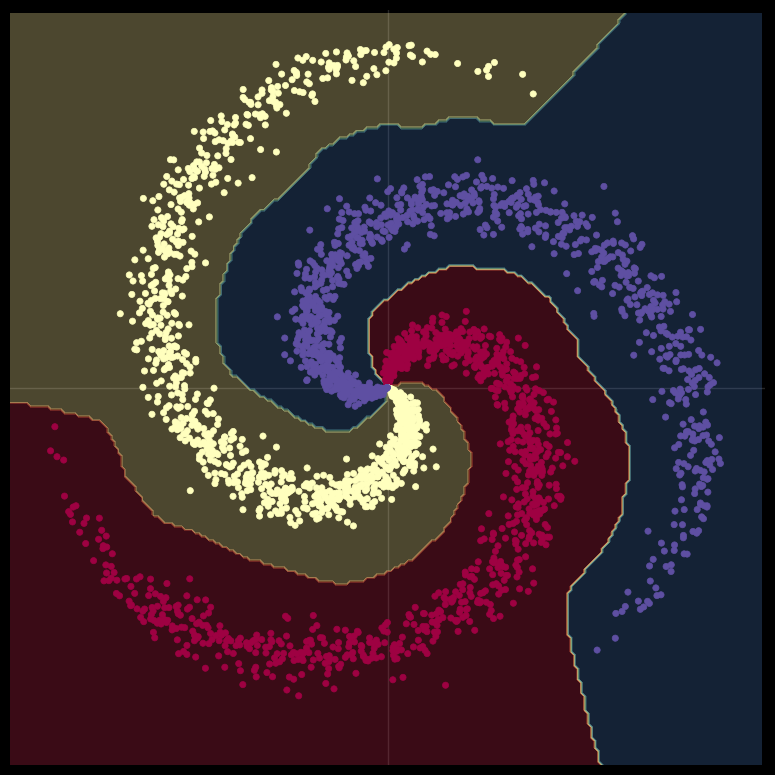

In [19]:
print(model)
plot_model(X, y, model)